<a href="https://colab.research.google.com/github/Rodizo/CS231N-Standford/blob/main/Copy_of_PT2_Time_Series_Forecasting_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
# color_pal = sns.color_palette()
# plt.style.use('fivethirtyeight')


from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_excel('/content/gdrive/My Drive/processed_dataset.xlsx')

Mounted at /content/gdrive


In [ ]:
data = data.set_index('Datetime')
data.index = pd.to_datetime(data.index)


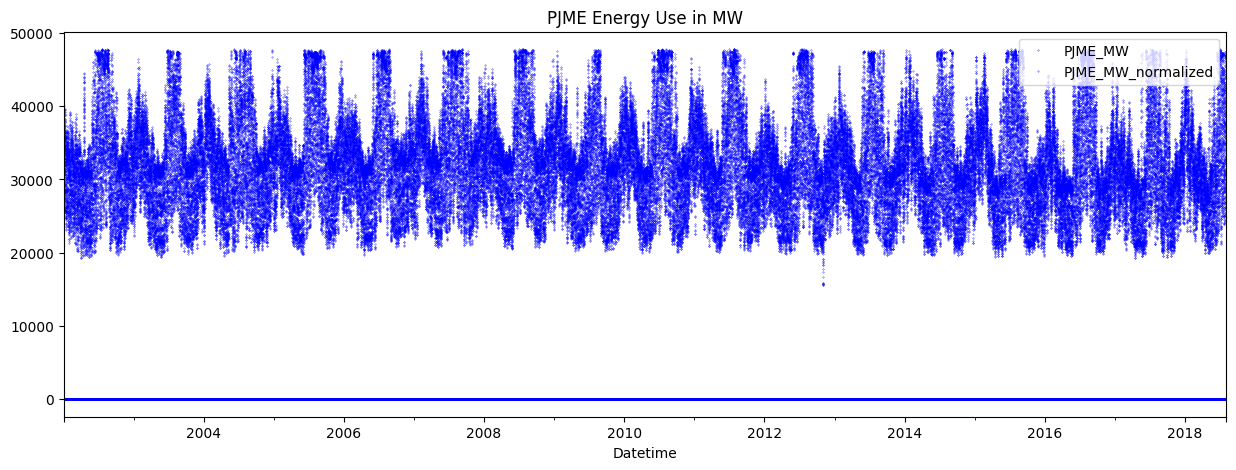

In [ ]:
data.plot(style='.',
        figsize=(15, 5),
        color='blue',
        title='PJME Energy Use in MW',
        markersize = 0.5)
plt.show()

# 1. Outlier Analysis and removal

<Axes: ylabel='Frequency'>

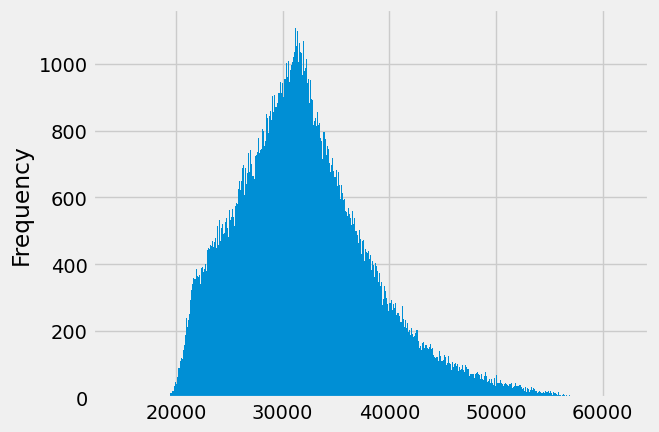

In [ ]:
# data['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

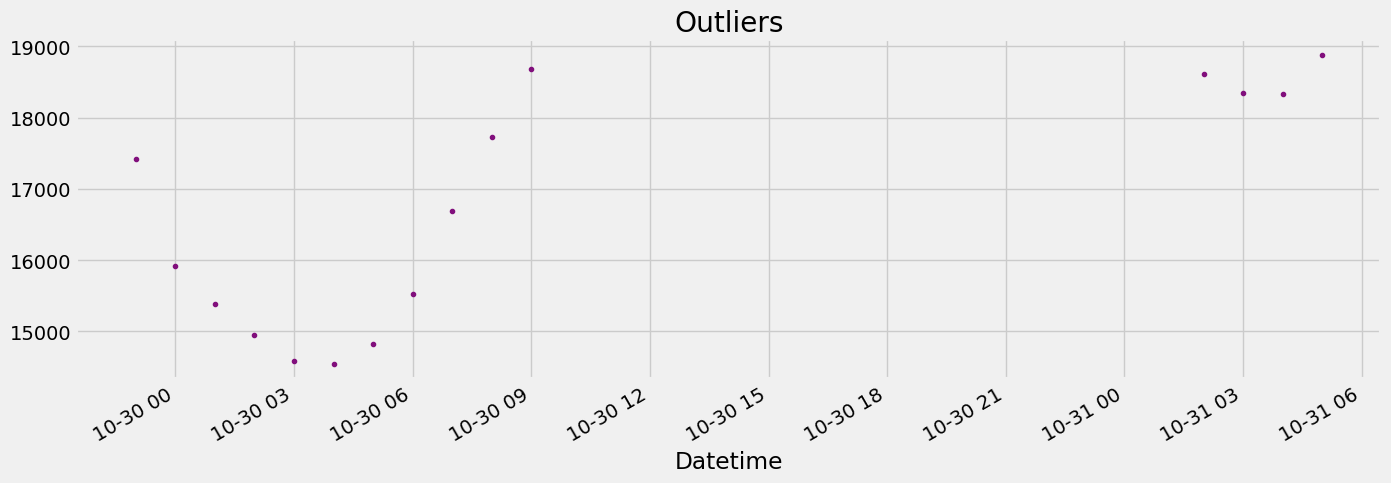

In [ ]:
# data.query('PJME_MW < 19_000')['PJME_MW'] \
#     .plot(style='.',
#           figsize=(15, 5),
#           color=color_pal[5],
#           title='Outliers')

In [ ]:
# data = data.query('PJME_MW > 19_000').copy()

# Reviewing: Train / Test Split

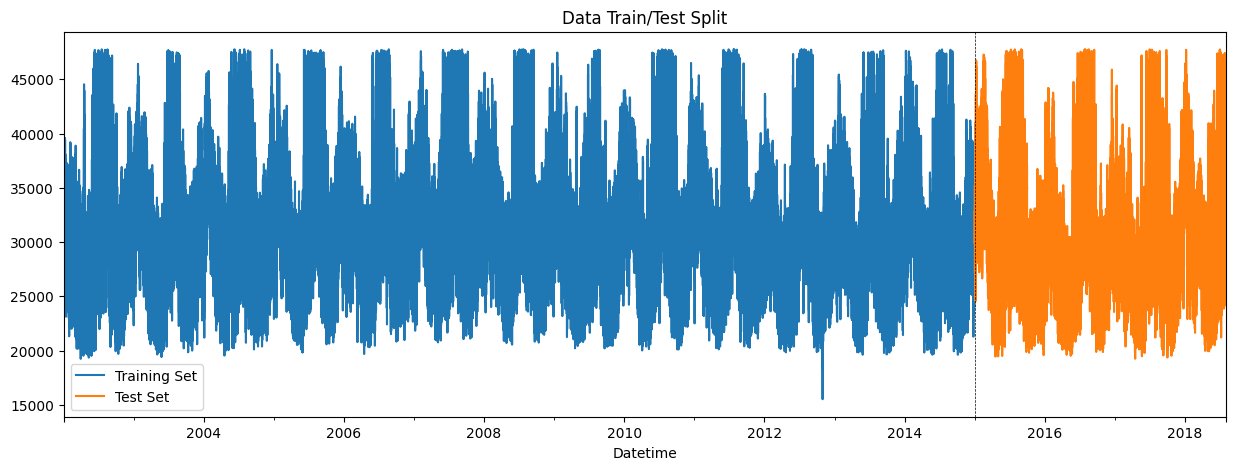

In [ ]:
train = data.loc[data.index < '01-01-2015']
test = data.loc[data.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
# Plot only the PJME_MW column for both training and test sets
train['PJME_MW'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['PJME_MW'].plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--', linewidth=0.5)
ax.legend(['Training Set', 'Test Set'])
plt.show()

# 1. Time Series Cross Validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=8, test_size=24*365*1, gap=24)
data = data.sort_index()

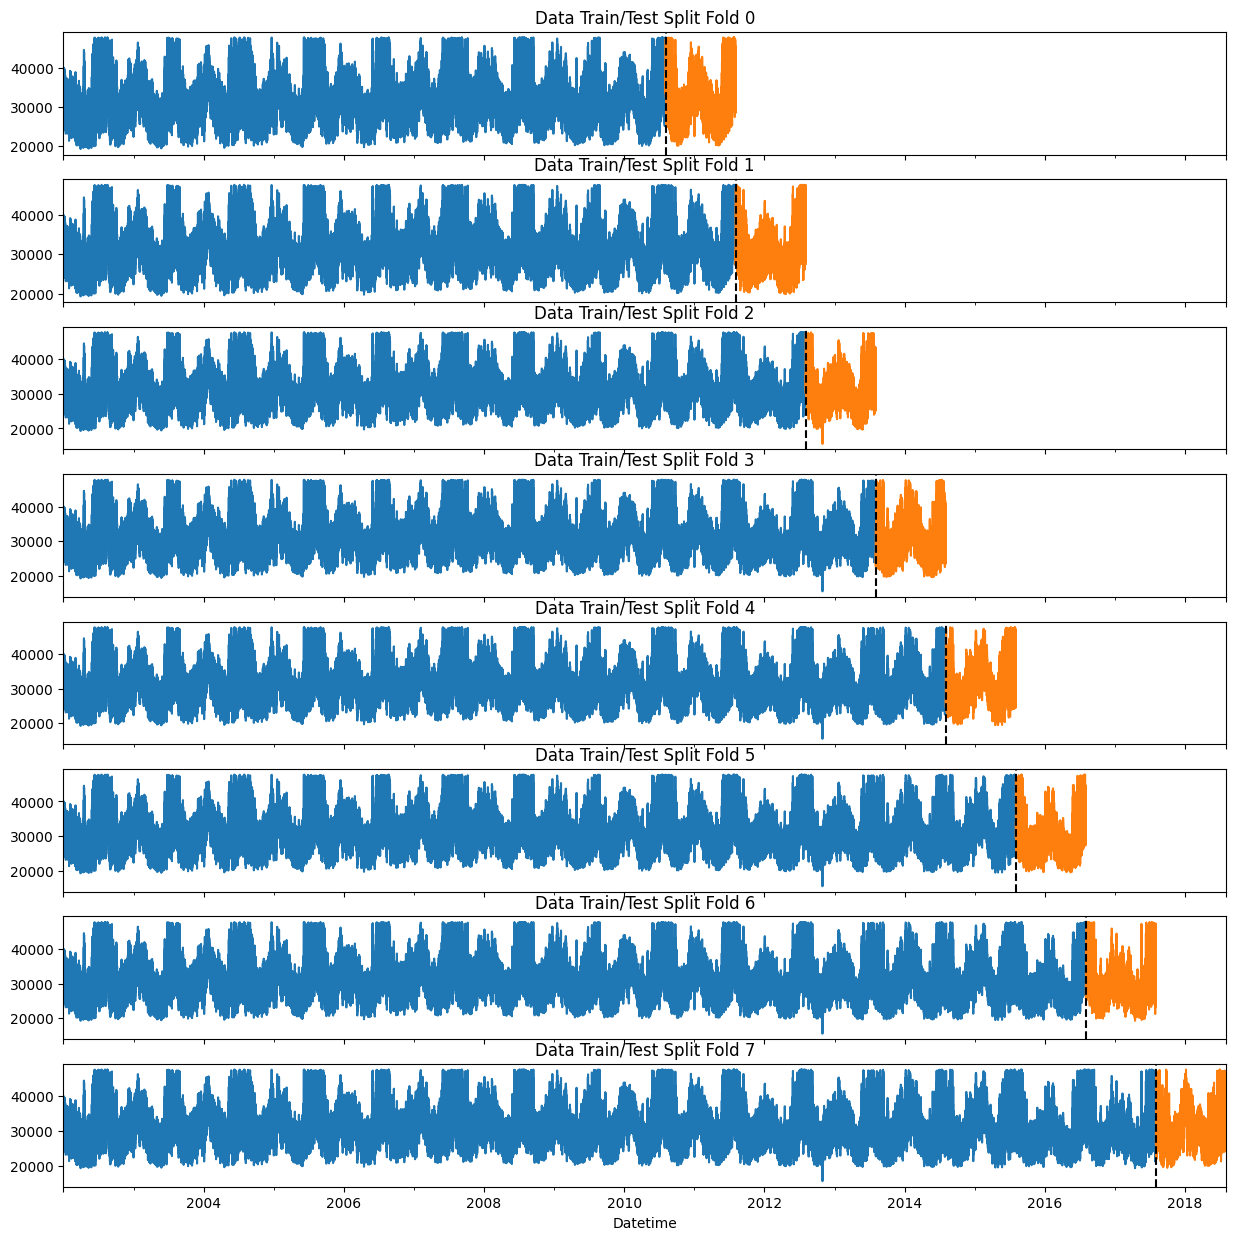

In [ ]:
fig, axs = plt.subplots(8, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(data):
    train = data.iloc[train_idx]
    test = data.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# 2. Forecasting Horizon Explained
**The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).**

In [ ]:
def create_features(data):
    """
    Create time series features based on time series index.
    """
    data = data.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['dayofyear'] = data.index.dayofyear
    data['dayofmonth'] = data.index.day
    data['weekofyear'] = data.index.isocalendar().week
    return data

data = create_features(data)

# 3. Lag Features
- What was the target (x) days in the past.

In [ ]:
def add_lags(data):
    target_map = data['PJME_MW'].to_dict()
    data['lag1'] = (data.index - pd.Timedelta('364 days')).map(target_map)
    data['lag2'] = (data.index - pd.Timedelta('728 days')).map(target_map)
    data['lag3'] = (data.index - pd.Timedelta('1092 days')).map(target_map)
    return data

In [ ]:
data = add_lags(data)

## Train Using Cross Validation

In [ ]:
!pip install bayesian-optimization
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

# Generate features using a rolling window approach
window_size = 3  # Example window size
for i in range(1, window_size + 1):
    data[f'lag_{i}'] = data['PJME_MW'].shift(i)

# Drop rows with NaN values caused by shifting
data = data.dropna()

# Define features and target
X = data[[f'lag_{i}' for i in range(1, window_size + 1)]]
y = data['PJME_MW']

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def xgb_evaluate(max_depth, gamma, colsample_bytree, subsample, min_child_weight):
    params = {
        'eval_metric': 'rmse',
        'max_depth': int(max_depth),
        'subsample': subsample,
        'eta': 0.1,
        'gamma': gamma,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': min_child_weight
    }

    # Ensure to use TimeSeriesSplit for time series data
    cv = TimeSeriesSplit(n_splits=5)
    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = xgb.XGBRegressor(**params, objective='reg:squarederror')
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        cv_scores[idx] = mape(y_test, predictions)  # Use MAPE here

    return -np.mean(cv_scores)  # Negative RMSE for maximization

TARGET = 'y'  # Assuming 'y' is your target variable

bounds = {
    'max_depth': (3, 10),
    'gamma': (0, 5),
    'colsample_bytree': (0.3, 1.0),
    'subsample': (0.4, 1.0),
    'min_child_weight': (1, 10)
}

optimizer = BayesianOptimization(f=xgb_evaluate, pbounds=bounds, random_state=42)
optimizer.maximize(init_points=10, n_iter=25)


|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------
| 1         | -4.715    | 0.5622    | 4.754     | 8.124     | 6.388     | 0.4936    |
| 2         | -4.717    | 0.4092    | 0.2904    | 9.063     | 6.41      | 0.8248    |
| 3         | -4.715    | 0.3144    | 4.85      | 8.827     | 2.911     | 0.5091    |
| 4         | -4.694    | 0.4284    | 1.521     | 6.673     | 4.888     | 0.5747    |
| 5         | -1.887    | 0.7283    | 0.6975    | 5.045     | 4.297     | 0.6736    |
| 6         | -1.797    | 0.8496    | 0.9984    | 6.6       | 6.332     | 0.4279    |
| 7         | -2.237    | 0.7253    | 0.8526    | 3.455     | 9.54      | 0.9794    |
| 8         | -2.231    | 0.8659    | 1.523     | 3.684     | 7.158     | 0.6641    |
| 9         | -4.699    | 0.3854    | 2.476     | 3.241     | 9.184     | 0.5553    |
| 10        | -1.798    | 0.7638    | 1.559     | 6.64

In [ ]:
print(optimizer.max['params'])
# Train the model with the best parameters found
best_params = {k: int(v) if k == 'max_depth' else v for k, v in optimizer.max['params'].items()}
model = xgb.XGBRegressor(**best_params, objective='reg:squarederror')
model.fit(X, y)  # Training on the full dataset or consider using a separate test set

{'colsample_bytree': 1.0, 'gamma': 2.3188976865133566, 'max_depth': 6.462555290120515, 'min_child_weight': 9.138065329208406, 'subsample': 0.4}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2.3188976865133566, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=9.138065329208406, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
data = data.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(data):
    train = data.iloc[train_idx]
    test = data.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=6,  # Best value found
                       learning_rate=0.01,
                       colsample_bytree=1.0,  # Best value found
                       gamma=2.3188976865133566,  # Best value found
                       min_child_weight=9.138065329208406,  # Best value found
                       subsample=0.4)  # Best value found

    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = mape(y_test, y_pred)  # Calculate MAPE instead of RMSE
    scores.append(score)

[0]	validation_0-rmse:32706.20087	validation_1-rmse:31897.25791
[100]	validation_0-rmse:12319.59655	validation_1-rmse:12154.67848
[200]	validation_0-rmse:5229.16226	validation_1-rmse:5696.39737
[300]	validation_0-rmse:3131.32174	validation_1-rmse:4051.31842
[400]	validation_0-rmse:2636.23296	validation_1-rmse:3735.36200
[500]	validation_0-rmse:2453.02696	validation_1-rmse:3637.75799
[600]	validation_0-rmse:2336.04367	validation_1-rmse:3591.37078
[700]	validation_0-rmse:2259.75923	validation_1-rmse:3579.20019
[800]	validation_0-rmse:2196.04477	validation_1-rmse:3571.33990
[899]	validation_0-rmse:2135.04180	validation_1-rmse:3570.81515
[0]	validation_0-rmse:32623.39860	validation_1-rmse:32089.09128
[100]	validation_0-rmse:12302.13173	validation_1-rmse:12508.16836
[200]	validation_0-rmse:5257.19715	validation_1-rmse:5863.74360
[300]	validation_0-rmse:3192.41625	validation_1-rmse:3903.20507
[400]	validation_0-rmse:2708.03005	validation_1-rmse:3438.40280
[500]	validation_0-rmse:2533.04918	v

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 8.2579
Fold scores:[8.197166523167041, 7.099411313961264, 8.507207069391512, 8.680429786715074, 8.805143699813836]


# 4. Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [ ]:
# Retrain on all data
data = create_features(data)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = data[FEATURES]
y_all = data[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                    booster='gbtree',
                    n_estimators=1000,
                    early_stopping_rounds=50,
                    objective='reg:squarederror',
                    max_depth=6,  # Best value found
                    learning_rate=0.01,
                    colsample_bytree=1.0,  # Best value found
                    gamma=2.3188976865133566,  # Best value found
                    min_child_weight=9.138065329208406,  # Best value found
                    subsample=0.4)  # Best value found

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32279.67217
[100]	validation_0-rmse:12212.98038
[200]	validation_0-rmse:5313.80452
[300]	validation_0-rmse:3343.97777
[400]	validation_0-rmse:2894.09554
[500]	validation_0-rmse:2734.33573
[600]	validation_0-rmse:2633.03640
[700]	validation_0-rmse:2552.09207
[800]	validation_0-rmse:2491.49906
[900]	validation_0-rmse:2438.33907
[999]	validation_0-rmse:2384.82693


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2.3188976865133566, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=9.138065329208406, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
data.index.max()

Timestamp('2018-08-03 00:00:00')

In [ ]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_data = pd.DataFrame(index=future)
future_data['isFuture'] = True
data['isFuture'] = False
data_and_future = pd.concat([data, future_data])
data_and_future = create_features(data_and_future)
data_and_future = add_lags(data_and_future)

In [ ]:
future_w_features = data_and_future.query('isFuture').copy()

## Predict the future

In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

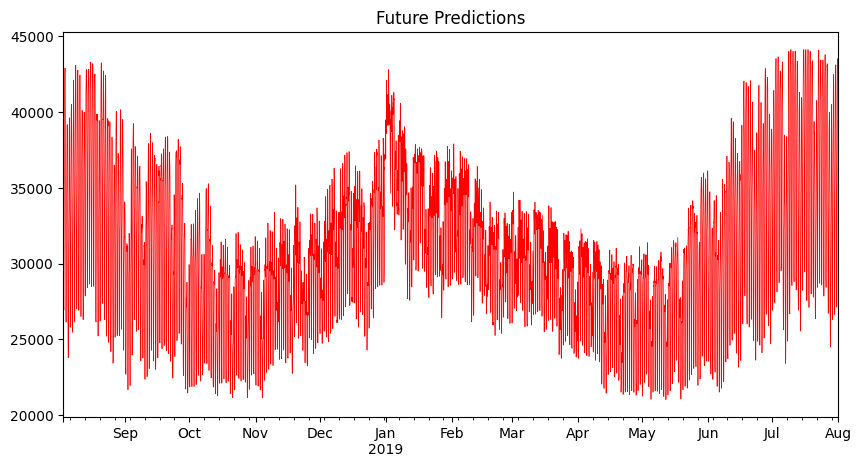

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color='red',
                               ms=1,
                               lw=0.5,
                               title='Future Predictions')
plt.show()

# Bonus: Saving Model For later

In [ ]:
# Save model
reg.save_model('model.json')

In [ ]:
!ls -lh

total 7.2M
-rw-r--r-- 1 root root 3.3M Apr 15 14:49 model.json
-rw-r--r-- 1 root root 3.9M Apr 15 14:26 processed_dataset.xlsx
drwxr-xr-x 1 root root 4.0K Apr 11 13:21 sample_data


<Axes: title={'center': 'Future Predictions'}>

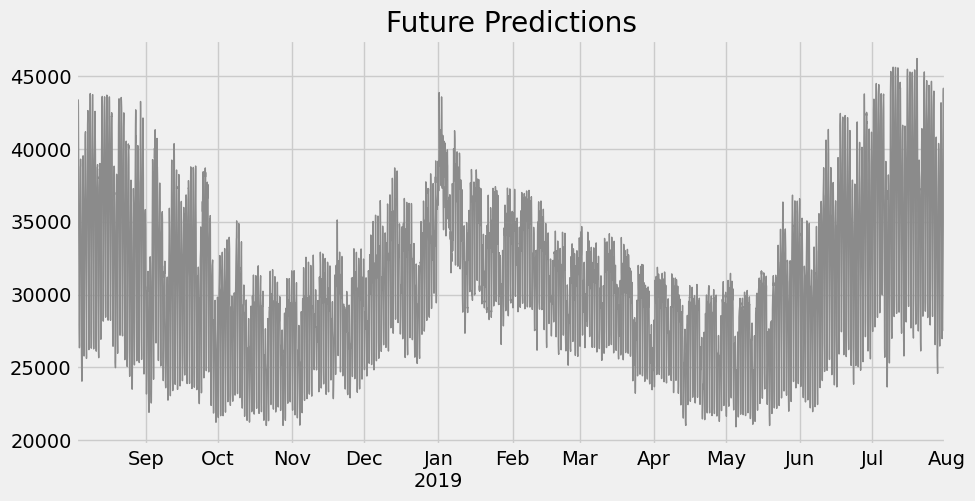

In [ ]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')

In [ ]:
pip install bayesian-optimization


# The End